# <a name="C1">Préparation des données</a>

#### Importation des librairies

In [64]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

import scipy.stats as st

#### Importation des données

In [65]:
raw_df = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv', low_memory=False)

#### Première revue & sélection initiale des variables

In [66]:
raw_df.shape

(3376, 46)

In [67]:
raw_df.T

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375
OSEBuildingID,1,2,3,5,8,9,10,11,12,13,...,50210,50212,50219,50220,50221,50222,50223,50224,50225,50226
DataYear,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
BuildingType,NonResidential,NonResidential,NonResidential,NonResidential,NonResidential,Nonresidential COS,NonResidential,NonResidential,NonResidential,Multifamily MR (5-9),...,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS,Nonresidential COS
PrimaryPropertyType,Hotel,Hotel,Hotel,Hotel,Hotel,Other,Hotel,Other,Hotel,Mid-Rise Multifamily,...,Office,Other,Mixed Use Property,Office,Other,Office,Other,Other,Mixed Use Property,Mixed Use Property
PropertyName,Mayflower park hotel,Paramount Hotel,5673-The Westin Seattle,HOTEL MAX,WARWICK SEATTLE HOTEL (ID8),West Precinct,Camlin,Paramount Theatre,311wh-Pioneer Square,Lyon Building,...,Central West HQ / Brown Bear,Conservatory Campus,Garfield Community Center,Genesee/SC SE HQ,High Point Community Center,Horticulture building,International district/Chinatown CC,Queen Anne Pool,South Park Community Center,Van Asselt Community Center
Address,405 Olive way,724 Pine street,1900 5th Avenue,620 STEWART ST,401 LENORA ST,810 Virginia St,1619 9th Avenue,911 Pine St,612 2nd Ave,607 - 3rd Ave.,...,1403 w howe,1400 E Galer St,2323 East Cherry St,4420 S Genesee,6920 34th Ave SW,1600 S Dakota St,719 8th Ave S,1920 1st Ave W,8319 8th Ave S,2820 S Myrtle St
City,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,...,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle,Seattle
State,WA,WA,WA,WA,WA,WA,WA,WA,WA,WA,...,WA,WA,WA,WA,WA,WA,WA,WA,WA,WA
ZipCode,98101.0,98101.0,98101.0,98101.0,98121.0,98101.0,98101.0,98101.0,98104.0,98104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TaxParcelIdentificationNumber,0659000030,0659000220,0659000475,0659000640,0659000970,0660000560,0660000825,0660000955,0939000080,0939000105,...,2425039137,2925049087,7544800245,4154300585,2524039059,1624049080,3558300000,1794501150,7883603155,7857002030


In [68]:
df = raw_df

In [69]:
df.DataYear.value_counts()

DataYear
2016    3376
Name: count, dtype: int64

In [70]:
irrelevant_domain_vars = [
    'OSEBuildingID',
     'DataYear',
     'PropertyName',
     'Address',
     'City',
     'State',
     'TaxParcelIdentificationNumber',
     'DefaultData',
     'Comments',
    'ComplianceStatus',
    'Outlier',
]

In [71]:
df = df.drop(irrelevant_domain_vars, axis=1)

Les informations contenues dans ces variables n'apporteront rien à mon modèle; je les supprime.

In [72]:
duplicate_energy_vars = [
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)', 
    'SiteEnergyUseWN(kBtu)', 
    'Electricity(kWh)',
    'NaturalGas(therms)',
]

In [73]:
df = df.drop(columns=duplicate_energy_vars)

Ces variables sont en doublon d'autres variables de relevé énergetique. Je choisis de garder une unité commune (le kBtu).

In [74]:
df.shape

(3376, 28)

# <a name="C2">Nettoyage des données</a>

#### Valeurs hors du cadre du projet

Le projet se concentre sur les batîments non destinés à l'habitation. Il semble qu'une partie du dataset concerne ces bâtiments:

In [75]:
df.BuildingType.value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [77]:
non_housing_mask = ~(df.BuildingType.str.contains('Multifamily')) & ~(df.LargestPropertyUseType.fillna('Empty').str.contains('Multifamily'))
len(df) - len(df[non_housing_mask])

1720

In [78]:
df.BuildingType.value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [79]:
df = df[df.BuildingType.str.contains('Multifamily')]

A peu près la moitié des observations du dataset concernent des logements. Je les supprime.

In [81]:
df.duplicated().sum()

0

In [82]:
df[df.duplicated(subset=['Latitude', 'Longitude'])]

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
1680,Multifamily HR (10+),High-Rise Multifamily,98121.0,7,DOWNTOWN,47.61612,-122.34973,1980,1.0,18,...,Swimming Pool,0.0,NaN,67.0,4826430.000,0.0,3002811.0,1823618.0,117.79,0.94
2012,Multifamily LR (1-4),Low-Rise Multifamily,98118.0,2,GREATER DUWAMISH,47.54027,-122.28551,2001,1.0,3,...,NaN,NaN,NaN,3.0,7308538.000,0.0,4927628.0,2380909.0,160.80,1.32
2973,Multifamily MR (5-9),Mid-Rise Multifamily,98199.0,7,MAGNOLIA / QUEEN ANNE,47.65295,-122.39078,1968,1.0,5,...,NaN,NaN,NaN,48.0,1242478.750,0.0,1242478.0,0.0,8.66,0.21
3043,Multifamily MR (5-9),Mid-Rise Multifamily,98122.0,3,CENTRAL,47.61598,-122.30770,2002,1.0,5,...,Retail Store,2170.0,NaN,96.0,2918553.250,0.0,605914.0,2312639.0,127.05,1.73
3083,Multifamily LR (1-4),Low-Rise Multifamily,98125.0,5,North,47.71025,-122.32020,1970,1.0,2,...,NaN,NaN,NaN,56.0,1232210.000,0.0,1232210.0,0.0,8.59,0.28
3119,Multifamily MR (5-9),Mid-Rise Multifamily,98199.0,7,MAGNOLIA / QUEEN ANNE,47.65201,-122.38910,1970,1.0,5,...,NaN,NaN,NaN,40.0,1034941.313,0.0,1034941.0,0.0,7.21,0.21
3139,Multifamily LR (1-4),Low-Rise Multifamily,98133.0,5,NORTHWEST,47.72883,-122.34862,1990,1.0,4,...,NaN,NaN,NaN,100.0,644415.000,0.0,644415.0,0.0,4.49,0.13
3263,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,4,NORTHEAST,47.67790,-122.26166,2013,1.0,2,...,NaN,NaN,NaN,35.0,1075019.375,0.0,1075019.0,0.0,7.49,0.23


Pas de doublons apparents.

#### Valeurs manquantes

In [83]:
df.isnull().sum()

BuildingType                          0
PrimaryPropertyType                   0
ZipCode                               0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     6
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             7
LargestPropertyUseType               14
LargestPropertyUseTypeGFA            14
SecondLargestPropertyUseType        884
SecondLargestPropertyUseTypeGFA     884
ThirdLargestPropertyUseType        1465
ThirdLargestPropertyUseTypeGFA     1465
YearsENERGYSTARCertified           1687
ENERGYSTARScore                     269
SiteEnergyUse(kBtu)                   3
SteamUse(kBtu)                        7
Electricity(kBtu)                     7


In [84]:
df = df.drop(columns=[
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 
    'ThirdLargestPropertyUseType', 
    'ThirdLargestPropertyUseTypeGFA',
    'YearsENERGYSTARCertified',
])

Je supprime les colonnes ayant trop de valeurs manquantes pour réaliser une imputation.

In [85]:
for var in df.columns:
    if df[var].isnull().sum() <= 20:
        df = df[~df[var].isnull()]

Je supprime les observations manquantes pour les variables ayant un taux très faible de valeurs manquantes, me permettant de garder un dataset fourni.

In [86]:
df['MissingENERGYSTARScore'] = False
df.loc[df.ENERGYSTARScore.isnull(), 'MissingENERGYSTARScore'] = True
df.loc[df.ENERGYSTARScore.isnull(), 'ENERGYSTARScore'] = df.ENERGYSTARScore.median()

J'impute l'ENERGY STAR Score par la médiane, et garde une trace des valeurs manquantes.

In [87]:
df.isnull().sum()

BuildingType                 0
PrimaryPropertyType          0
ZipCode                      0
CouncilDistrictCode          0
Neighborhood                 0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFATotal             0
PropertyGFAParking           0
PropertyGFABuilding(s)       0
ListOfAllPropertyUseTypes    0
LargestPropertyUseType       0
LargestPropertyUseTypeGFA    0
ENERGYSTARScore              0
SiteEnergyUse(kBtu)          0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
GHGEmissionsIntensity        0
MissingENERGYSTARScore       0
dtype: int64

In [88]:
df.shape

(1694, 24)

#### Outliers

In [92]:
def filter_out_outliers(df, var):
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df[var] >= Q1 - 1.5 * IQR) & (df[var] <= Q3 + 1.5 *IQR)
    return df[filter]

In [93]:
vars = df.select_dtypes(include=['int64', 'float64']).columns
    
for var in vars:
    print(var, len(df) - len(filter_out_outliers(df, var)))

ZipCode 57
CouncilDistrictCode 0
Latitude 42
Longitude 4
YearBuilt 20
NumberofBuildings 88
NumberofFloors 94
PropertyGFATotal 167
PropertyGFAParking 169
PropertyGFABuilding(s) 175
LargestPropertyUseTypeGFA 173
ENERGYSTARScore 77
SiteEnergyUse(kBtu) 169
SteamUse(kBtu) 16
Electricity(kBtu) 164
NaturalGas(kBtu) 134
TotalGHGEmissions 146
GHGEmissionsIntensity 182


Beaucoup de colonnes ont des outliers (au sens statistique du terme); Je déciderai de la manière de les gérer durant le Feature Engineering.

# <a name="C2">Analyse des données</a>

In [94]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'MissingENERGYSTARScore'],
      dtype='object')

In [95]:
df.BuildingType.value_counts()

BuildingType
Multifamily LR (1-4)    1007
Multifamily MR (5-9)     579
Multifamily HR (10+)     108
Name: count, dtype: int64

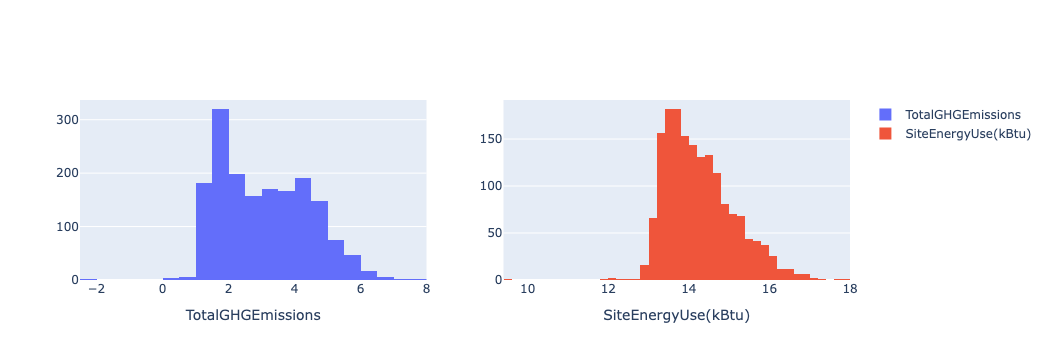

In [96]:
target_vars = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
fig = make_subplots(rows=1, cols=2)

for i, var in enumerate(target_vars):
    fig.add_trace(go.Histogram(x=df[var], nbinsx=50, name=var), row=(i//2)+1, col=(i%2)+1)
    fig.update_xaxes(title_text=var,row=(i//2)+1, col=(i%2)+1)
fig.show()

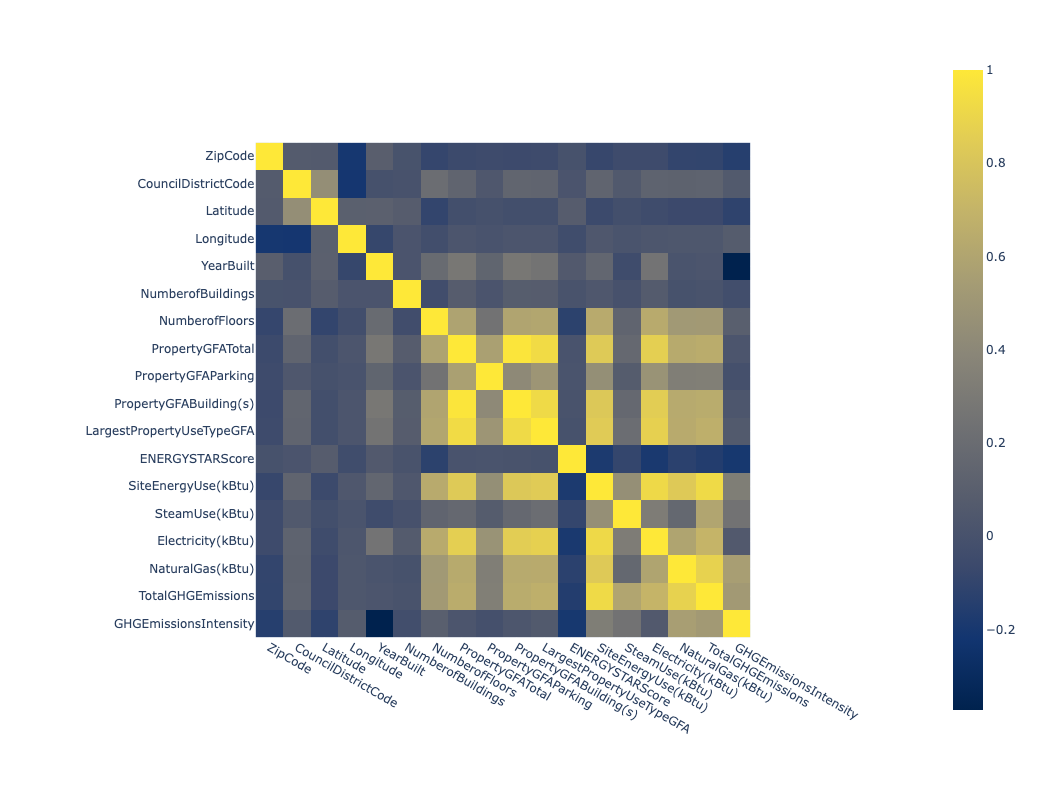

In [97]:
fig = px.imshow(df.select_dtypes(include=['int64', 'float64']).corr(), color_continuous_scale='cividis')
fig.update_layout(width=800, height=800)
fig.show()

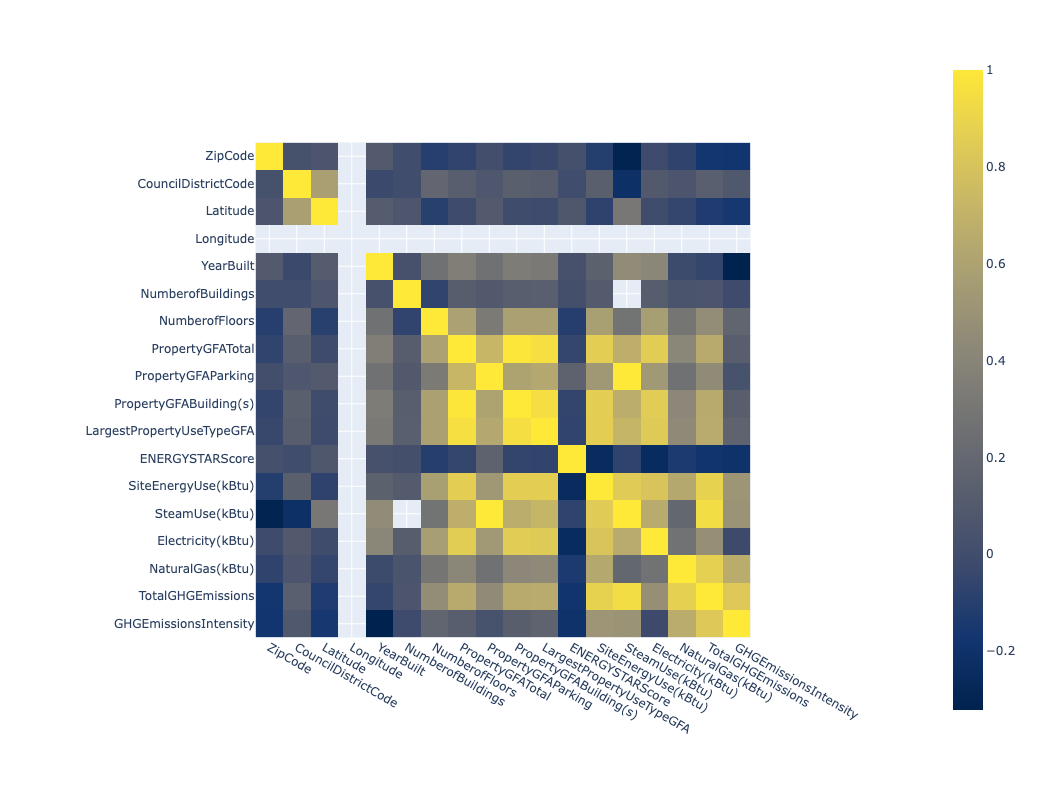

In [98]:
fig = px.imshow(np.log(df.select_dtypes(include=['int64', 'float64'])).corr(), color_continuous_scale='cividis')
fig.update_layout(width=800, height=800)
fig.show()

In [99]:
df.PrimaryPropertyType.value_counts()

PrimaryPropertyType
Low-Rise Multifamily           973
Mid-Rise Multifamily           563
High-Rise Multifamily          103
Senior Care Community           25
Mixed Use Property              19
Other                            6
Residence Hall                   2
Small- and Mid-Sized Office      1
University                       1
Hotel                            1
Name: count, dtype: int64

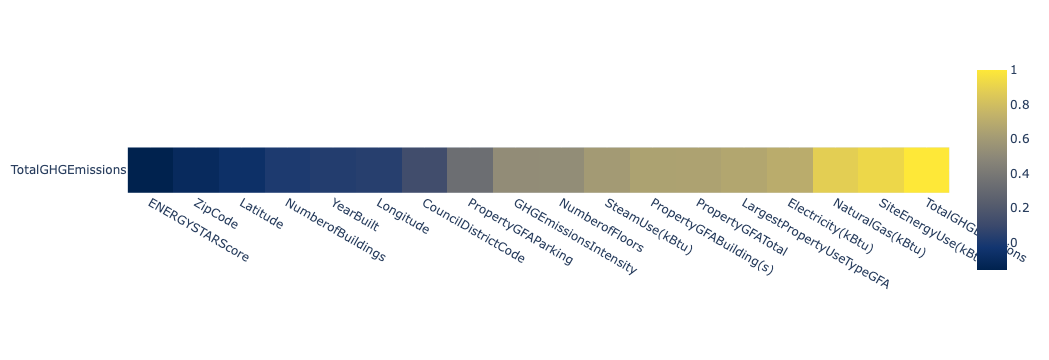

In [100]:
df_corr = df.select_dtypes(include=['int64', 'float64']).corr()
df_corr = df_corr.sort_values(by='TotalGHGEmissions')[['TotalGHGEmissions']].T
px.imshow(df_corr, color_continuous_scale='cividis')

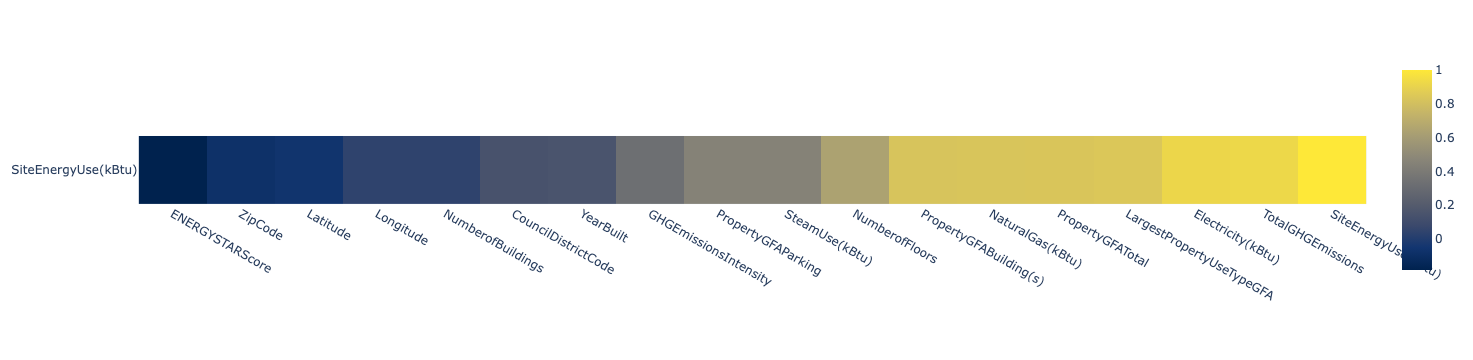

In [101]:
df_corr = df.select_dtypes(include=['int64', 'float64']).corr()
df_corr = df_corr.sort_values(by='SiteEnergyUse(kBtu)')[['SiteEnergyUse(kBtu)']].T
px.imshow(df_corr, color_continuous_scale='cividis')

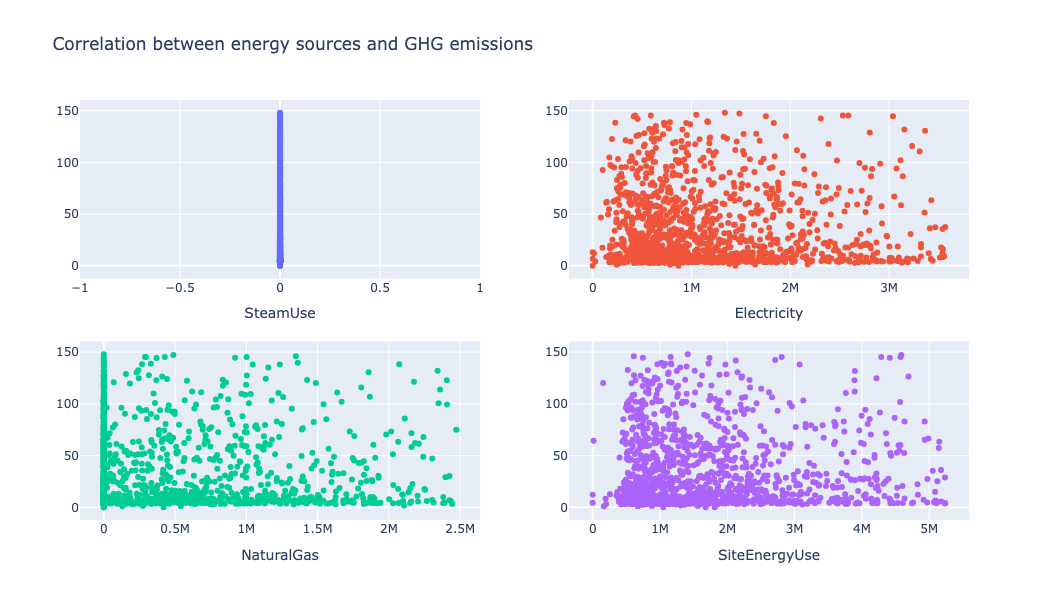

In [102]:

energy_vars = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SiteEnergyUse(kBtu)']
fig = make_subplots(rows=2, cols=2)

for i, var in enumerate(energy_vars):
    row = (i//2)+1
    col=(i%2)+1
    
    fig.add_trace(go.Scatter(x=filter_out_outliers(df, var)[var], y=filter_out_outliers(df, 'TotalGHGEmissions')['TotalGHGEmissions'], mode='markers'), row=row, col=col)
    fig.update_xaxes(title_text=var[:-6], row=row, col=col)

fig.update_layout(height=600, width= 1000, showlegend=False, title='Correlation between energy sources and GHG emissions')
fig.show()

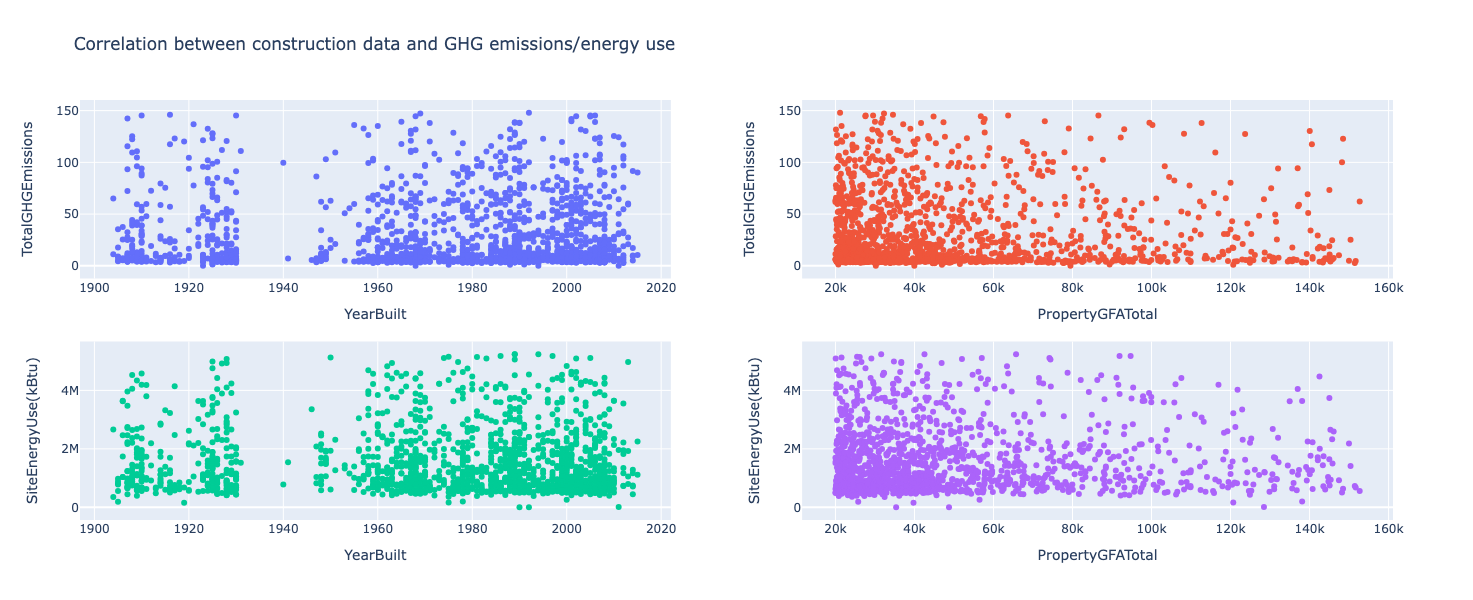

In [103]:
continuous_housing_vars = ['YearBuilt', 'PropertyGFATotal']
fig = make_subplots(rows=2, cols=2)

for j, target_var in enumerate(target_vars):
    for i, var in enumerate(continuous_housing_vars):
        row = (i//2)+ 1 + j
        col=(i%2)+1
            
        fig.add_trace(go.Scatter(x=filter_out_outliers(df, var)[var], y=filter_out_outliers(df, target_var)[target_var], mode='markers'), row=row, col=col)
        fig.update_xaxes(title_text=var, row=row, col=col)
        fig.update_yaxes(title_text= target_var, row=row, col=col)

fig.update_layout(height=600, width= 1000, showlegend=False, title='Correlation between construction data and GHG emissions/energy use')
fig.show()

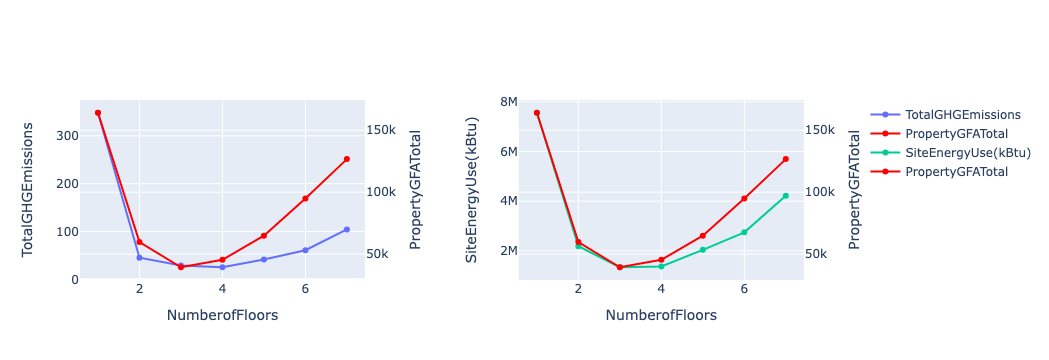

In [104]:
df_filtered = df.loc[df['NumberofFloors'].between(1,7)].groupby('NumberofFloors')[['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'PropertyGFATotal']].mean().reset_index()

fig = make_subplots(rows=1, cols=2, specs=[[{"secondary_y": True}, {"secondary_y": True}]])

for i, var in enumerate(target_vars):
    fig.add_trace(go.Scatter(x=df_filtered['NumberofFloors'], y=df_filtered[var], name=var), row=1, col=i+1, secondary_y=False)
    fig.update_yaxes(title_text=var, row=1, col=i+1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df_filtered['NumberofFloors'], y=df_filtered['PropertyGFATotal'], name='PropertyGFATotal', line=dict(color='red')), row=1, col=i+1, secondary_y=True)
    fig.update_yaxes(title_text='PropertyGFATotal', row=1, col=i+1, secondary_y=True)
    fig.update_xaxes(title_text='NumberofFloors', row=1, col=i+1)

fig.show()

In [105]:
df_agg = df.groupby(['NumberofFloors', 'PrimaryPropertyType']).agg({'TotalGHGEmissions': 'sum'}).reset_index()
sizes = df.loc[raw_df['NumberofFloors'].between(1,7)].groupby(['NumberofFloors', 'PrimaryPropertyType']).size().reset_index(name='size')
df_prop = df_agg.merge(sizes, on=['NumberofFloors', 'PrimaryPropertyType'])
df_prop['GHG_share'] = df_prop['TotalGHGEmissions'] / df_prop.groupby('NumberofFloors')['TotalGHGEmissions'].transform('sum') * 100
df_prop['prop_share'] = df_prop['size'] / df_prop.groupby('NumberofFloors')['size'].transform('sum') * 100

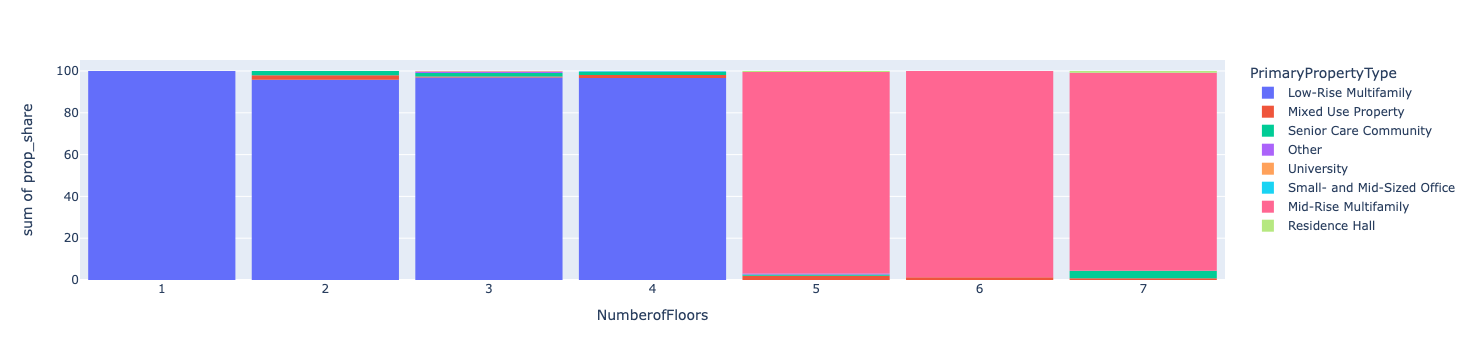

In [106]:
fig = px.histogram(df_prop, x="NumberofFloors", y='prop_share', color='PrimaryPropertyType', nbins=len(df_prop['NumberofFloors'].unique()))
fig.update_layout(bargap=0.1)
fig.show()

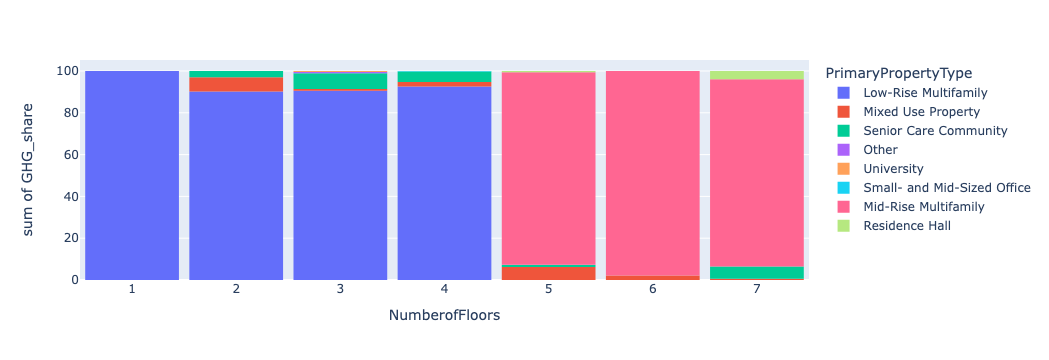

In [107]:
fig = px.histogram(df_prop, x="NumberofFloors", y='GHG_share', color='PrimaryPropertyType', nbins=len(df_prop['NumberofFloors'].unique()))
fig.update_layout(bargap=0.1)
fig.show()

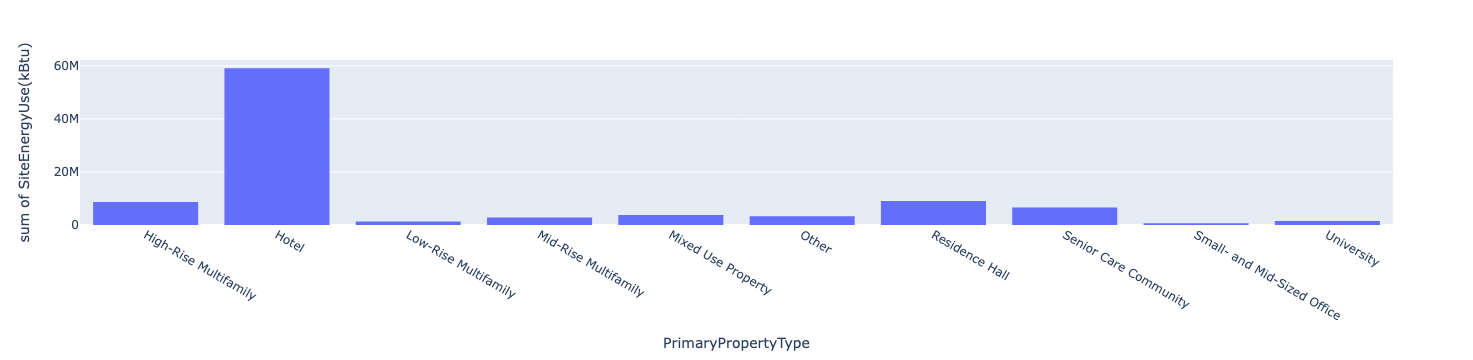

In [108]:
average_energy_use = df.groupby('PrimaryPropertyType')[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].mean()
px.histogram(average_energy_use.reset_index(), x='PrimaryPropertyType', y='SiteEnergyUse(kBtu)' )

In [109]:
df[df.NumberofFloors.between(3,4)].sort_values(by='SiteEnergyUse(kBtu)', ascending=False).head(10)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,MissingENERGYSTARScore
3082,Multifamily LR (1-4),Low-Rise Multifamily,98125.0,5,NORTH,47.701880,-122.324590,2008,1.0,4,...,Multifamily Housing,102522.0,1.0,13459221.0,0.0,3963184.0,9496036.0,531.96,11.38,False
646,Multifamily LR (1-4),Senior Care Community,98144.0,3,CENTRAL,47.595050,-122.298240,1963,1.0,3,...,Senior Care Community,132804.0,72.0,9097980.0,0.0,3023688.0,6074292.0,343.68,5.18,False
2675,Multifamily LR (1-4),Low-Rise Multifamily,98115.0,6,NORTHWEST,47.678150,-122.326130,2008,1.0,4,...,Multifamily Housing,299642.0,85.0,8987012.0,0.0,5322021.0,3664990.0,231.75,1.21,False
3107,Multifamily LR (1-4),Mixed Use Property,98105.0,4,NORTHEAST,47.667090,-122.301490,2008,1.0,4,...,Senior Care Community,119826.0,98.0,7574092.0,0.0,6097687.0,1476405.0,120.92,0.47,False
2012,Multifamily LR (1-4),Low-Rise Multifamily,98118.0,2,GREATER DUWAMISH,47.540270,-122.285510,2001,1.0,3,...,Multifamily Housing,121635.0,3.0,7308538.0,0.0,4927628.0,2380909.0,160.80,1.32,False
2763,Multifamily LR (1-4),Low-Rise Multifamily,98104.0,2,DOWNTOWN,47.598580,-122.324700,1920,1.0,4,...,Multifamily Housing,46560.0,76.0,6881405.5,0.0,1756636.0,5124769.0,284.42,6.11,True
3049,Multifamily LR (1-4),Low-Rise Multifamily,98136.0,1,SOUTHWEST,47.538880,-122.392010,1951,0.0,4,...,Multifamily Housing,177686.0,76.0,6814269.0,0.0,5692544.0,1121724.0,99.26,0.49,True
3084,Multifamily LR (1-4),Senior Care Community,98178.0,3,EAST,47.500619,-122.220966,1995,1.0,3,...,Senior Care Community,132284.0,98.0,6723971.5,0.0,4318036.0,2405935.0,157.88,1.26,False
2221,Multifamily LR (1-4),Low-Rise Multifamily,98118.0,2,SOUTHEAST,47.548800,-122.286060,1964,1.0,3,...,Multifamily Housing,191330.0,54.0,6069855.0,0.0,5844237.0,225617.0,52.73,0.28,False
1493,Multifamily LR (1-4),Low-Rise Multifamily,98122.0,3,CENTRAL,47.609410,-122.316360,2000,1.0,4,...,Multifamily Housing,141603.0,29.0,5950438.5,0.0,5721599.0,228839.0,52.04,0.25,False


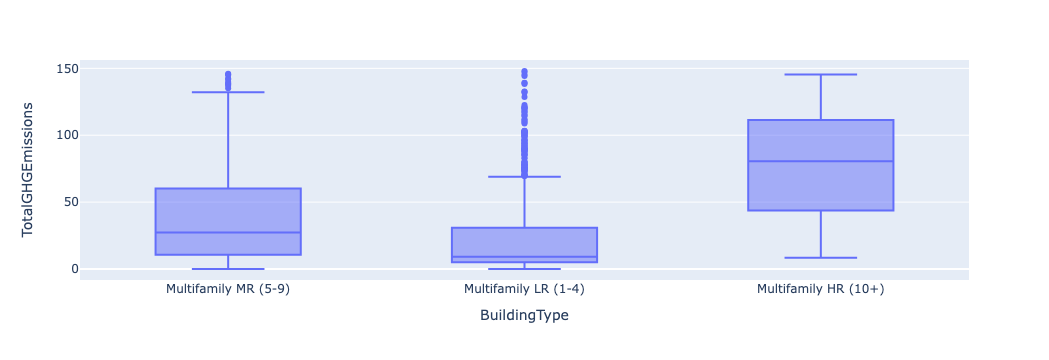

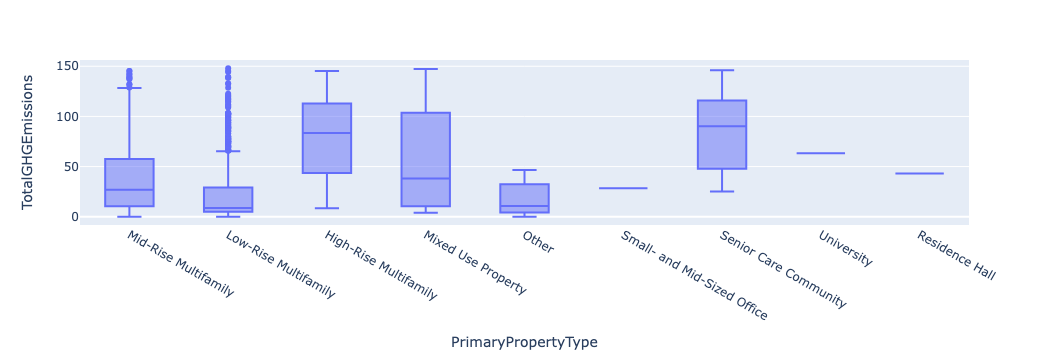

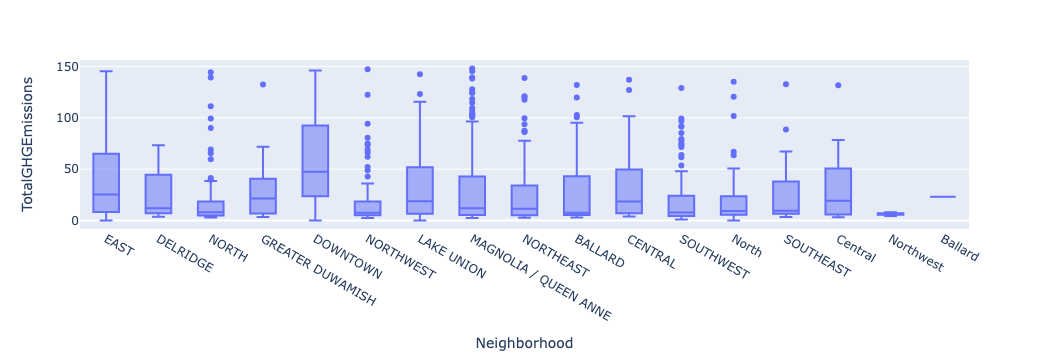

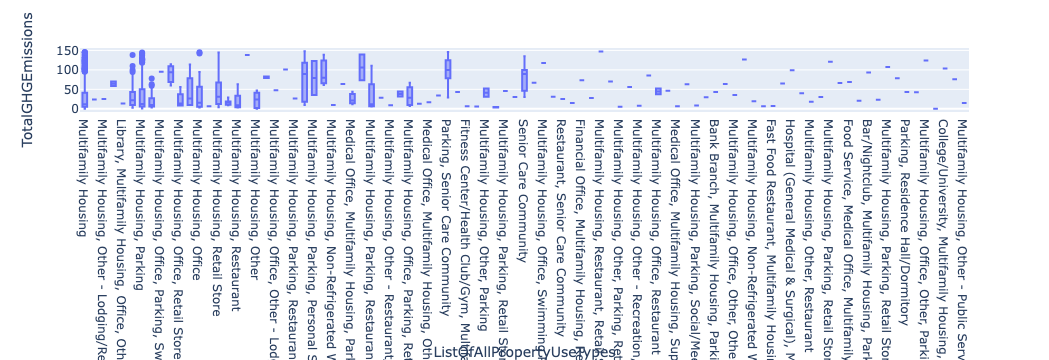

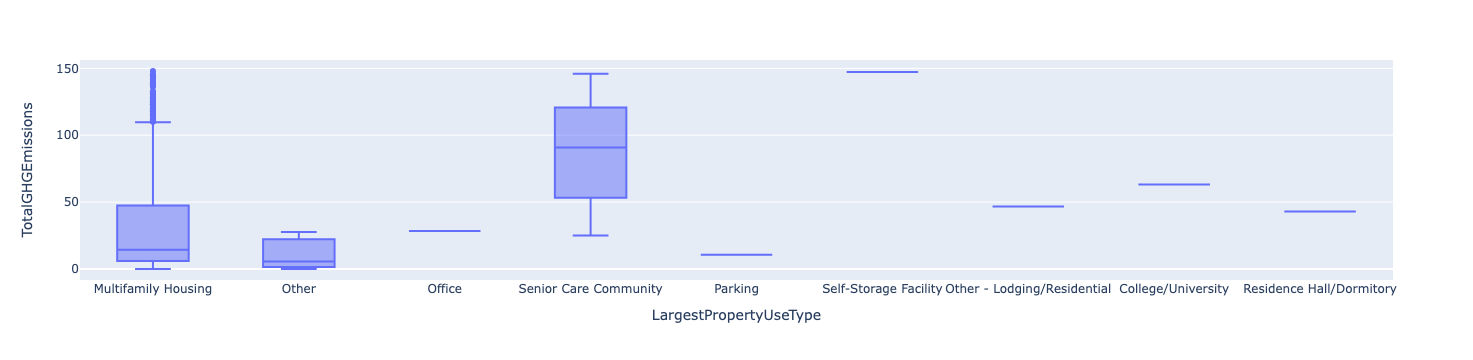

In [110]:
categorical_vars = df.select_dtypes(include='object')


for var in categorical_vars:
    fig = px.box(filter_out_outliers(df, target_vars[0]), x=var, y=target_vars[0])
    fig.show()

In [111]:
df.to_csv('data/clean_dataset.csv')